In [3]:
import multiprocessing as mp
import numpy as np
import commpy as cp
from commpy.channelcoding import Trellis
from commpy.modulation import QAMModem, PSKModem

# For visualization
import pylab
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
sns.set()

In [4]:
# https://stackoverflow.com/questions/34478398/import-local-function-from-a-module-housed-in-another-directory-with-relative-im
# a hack to import module from different directory
import os
import sys
import time
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

## Define Hyper-parameters

In [5]:
NUM_EXAMPLES = 10  # 9k samples train, 1k for dev, 1k for dev
BLOCK_LEN = 100
SNR_MAX   = 15 # [0.5,1] 100 
SNR       = SNR_MAX 

modem = QAMModem(4)  # Constellation  QAM16
trellis = Trellis(memory   = np.array([2]), 
                  g_matrix = np.array([[0o7, 0o5]]) , 
                  feedback = 0o7, 
                  code_type= 'rsc')

In [6]:
def generate_signal_over_awgn(modem, block_length=100, snr_dB=15.0):
    message_bits   = np.random.randint(0, 2, block_length)
    encoded_bits   = cp.channelcoding.conv_encode(message_bits, trellis)
    modulated_bits = modem.modulate(encoded_bits)
    corrupted_bits = cp.channels.awgn(modulated_bits, snr_dB, rate=1/2)
    
    return message_bits, modulated_bits, corrupted_bits

def signal_generator(modulation_scheme, num_examples, block_length, snr_dB):
    with mp.Pool(mp.cpu_count()) as pool:
        result = pool.starmap(generate_signal_over_awgn,
                iterable=[(modulation_scheme, block_length, snr_dB) \
                          for i in range(num_examples)])
        orignal_msg_bits, moded_bits, noisy_outputs = zip(*result)
    return (np.array(orignal_msg_bits), np.array(moded_bits), np.array(noisy_outputs))

## Train a RNN to estimate original message over noisy AWGN channel.

### Split data into training/dev/test

* Dev and Test set should have similar distribution.
* Split into 80/10/10.
* Adopt from : https://cs230-stanford.github.io/train-dev-test-split.html

In [7]:
import random 

# Generate data for training
original_bits, clean_signals, noisy_signals = signal_generator(modem, NUM_EXAMPLES, BLOCK_LEN, SNR)

# Split data into train/dev/test
dataset = list(zip(noisy_signals, original_bits))

# Shuffle Before splitting the data
random.shuffle(dataset)
split1 = int(0.8 * len(dataset))
split2 = int(0.9 * len(dataset))
train_set = dataset[:split1]
dev_set = dataset[split1:split2]
test_set = dataset[split2:]

print(len(train_set), len(dev_set), len(test_set))

8 1 1


In [8]:
NUM_CLASSES =  modem.m

def get_trainable_data(x, y):
    """Encode complex numbers to trainable data and one_hot labels"""
    
    x = np.array(x)[:, :100]
    y = np.array(y)
    x = np.stack((x.real, x.imag), axis=-1).reshape((-1, 100, 2))
    y = np.expand_dims(y, -1)  # (batch, block_length, 1)
    return x, y

x_train, y_train = zip(*train_set)
x_dev, y_dev = zip(*dev_set)
x_test, y_test = zip(*test_set)

X_train, Y_train = get_trainable_data(x_train, y_train)
X_dev, Y_dev = get_trainable_data(x_dev, y_dev)
X_test, Y_test = get_trainable_data(x_test, y_test)

print('Training data')
print('Trainable data:', X_train.shape, X_dev.shape, X_test.shape)
print('Groundtruths  :', Y_train.shape, Y_dev.shape, Y_test.shape)

Training data
Trainable data: (8, 100, 2) (1, 100, 2) (1, 100, 2)
Groundtruths  : (8, 100, 1) (1, 100, 1) (1, 100, 1)


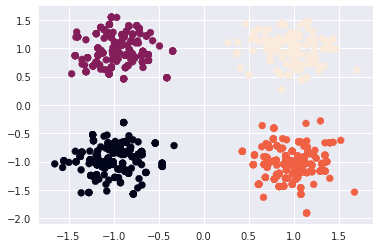

In [9]:
inputs = noisy_signals.flatten()[0:1000]
_, groundtruths = np.unique(clean_signals, return_inverse=True)
plt.scatter(np.real(inputs), np.imag(inputs), c=groundtruths[0:1000])

### Define a Recurrent  Neural network for estimating orginal message

In [ ]:
## Simple Classification
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, BatchNormalization
from tensorflow.keras.layers import GRU, Bidirectional, TimeDistributed

num_hidden_layers = 2
num_hidden_units = 400
num_classes = modem.m
dropout_rate = 0.5

tf.keras.backend.clear_session()

inputs  = Input(shape=(None, 2))
x = inputs
for _ in range(num_hidden_layers):
    x = Bidirectional(GRU(
        units=num_hidden_units,
        return_sequences=True,
        recurrent_dropout=dropout_rate))(x)
    x = BatchNormalization()(x)
outputs = TimeDistributed(Dense(1, activation='sigmoid'))(x)

model = tf.keras.Model(inputs, outputs)
model.summary()

In [ ]:

def BER(y, y_pred):
    hamming_distances =  tf.cast(tf.not_equal(y, tf.round(y_pred)), tf.int32)
    return tf.reduce_sum(hamming_distances) / tf.size(y)

def BLER(y, y_pred):
    num_blocks_per_batch = tf.cast(tf.shape(y)[0], tf.int64)
    hamming_distances =  tf.cast(tf.not_equal(y, tf.round(y_pred)), tf.int32)
    return tf.count_nonzero(tf.reduce_sum(hamming_distances, axis=1)) / num_blocks_per_batch

model.compile('adam','mse', metrics=[BER, BLER])

model.fit(X_train, Y_train, 
          validation_data=(X_dev, Y_dev), 
          epochs=5, batch_size=1)

_, accuracy = model.evaluate(X_test, Y_test)

print('Test Accuracy: %f' % accuracy)

In [ ]:
model.save('end2end.hdf5')